In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "400X"
trainable_blocks = ["block4"]
irun = 3


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_400X-BREAKHIS-Dataset-60-10-30-VGGINet/3'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/400X/3'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 971 files belonging to 2 classes.


Found 161 files belonging to 2 classes.


Found 488 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1245 - accuracy: 0.5938

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/8 [======>.......................] - ETA: 2s - loss: 5.9275 - accuracy: 0.6250

3/8 [==========>...................] - ETA: 4s - loss: 5.8212 - accuracy: 0.6589

4/8 [==============>...............] - ETA: 4s - loss: 5.4609 - accuracy: 0.6680

5/8 [=================>............] - ETA: 3s - loss: 5.1861 - accuracy: 0.6672

6/8 [=====================>........] - ETA: 2s - loss: 4.9411 - accuracy: 0.6810

7/8 [=========================>....] - ETA: 1s - loss: 4.7681 - accuracy: 0.6886

8/8 [==============================] - ETA: 0s - loss: 4.5717 - accuracy: 0.7003

8/8 [==============================] - 21s 3s/step - loss: 4.5717 - accuracy: 0.7003 - val_loss: 4.4942 - val_accuracy: 0.8820


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 4.4012 - accuracy: 0.7969

2/8 [======>.......................] - ETA: 11s - loss: 3.7708 - accuracy: 0.8125

3/8 [==========>...................] - ETA: 8s - loss: 3.6354 - accuracy: 0.8073 

4/8 [==============>...............] - ETA: 7s - loss: 3.1861 - accuracy: 0.8184

5/8 [=================>............] - ETA: 4s - loss: 2.9151 - accuracy: 0.8297

6/8 [=====================>........] - ETA: 2s - loss: 2.8505 - accuracy: 0.8268

7/8 [=========================>....] - ETA: 1s - loss: 2.7643 - accuracy: 0.8203

8/8 [==============================] - ETA: 0s - loss: 2.6778 - accuracy: 0.8198

8/8 [==============================] - 13s 2s/step - loss: 2.6778 - accuracy: 0.8198 - val_loss: 8.2837 - val_accuracy: 0.8199


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 2.4806 - accuracy: 0.7734

2/8 [======>.......................] - ETA: 11s - loss: 2.0267 - accuracy: 0.8203

3/8 [==========>...................] - ETA: 8s - loss: 1.7939 - accuracy: 0.8411 

4/8 [==============>...............] - ETA: 7s - loss: 1.8851 - accuracy: 0.8320

5/8 [=================>............] - ETA: 4s - loss: 1.8889 - accuracy: 0.8406

6/8 [=====================>........] - ETA: 3s - loss: 1.8262 - accuracy: 0.8464

7/8 [=========================>....] - ETA: 1s - loss: 1.9146 - accuracy: 0.8449

8/8 [==============================] - ETA: 0s - loss: 2.0010 - accuracy: 0.8435

8/8 [==============================] - 14s 2s/step - loss: 2.0010 - accuracy: 0.8435 - val_loss: 1.7214 - val_accuracy: 0.9379


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 1.7197 - accuracy: 0.8516

2/8 [======>.......................] - ETA: 11s - loss: 1.7780 - accuracy: 0.8750

3/8 [==========>...................] - ETA: 8s - loss: 1.4601 - accuracy: 0.8880 

4/8 [==============>...............] - ETA: 7s - loss: 1.4600 - accuracy: 0.8789

5/8 [=================>............] - ETA: 4s - loss: 1.4500 - accuracy: 0.8781

6/8 [=====================>........] - ETA: 2s - loss: 1.4789 - accuracy: 0.8711

7/8 [=========================>....] - ETA: 1s - loss: 1.5059 - accuracy: 0.8683

8/8 [==============================] - ETA: 0s - loss: 1.4536 - accuracy: 0.8723

8/8 [==============================] - 13s 2s/step - loss: 1.4536 - accuracy: 0.8723 - val_loss: 1.8785 - val_accuracy: 0.9193


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9172 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 2s - loss: 1.3690 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 3s - loss: 1.5302 - accuracy: 0.8906

4/8 [==============>...............] - ETA: 4s - loss: 1.3764 - accuracy: 0.8926

5/8 [=================>............] - ETA: 3s - loss: 1.3953 - accuracy: 0.8906

6/8 [=====================>........] - ETA: 2s - loss: 1.4345 - accuracy: 0.8828

7/8 [=========================>....] - ETA: 1s - loss: 1.4045 - accuracy: 0.8806

8/8 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.8826

8/8 [==============================] - 11s 1s/step - loss: 1.3983 - accuracy: 0.8826 - val_loss: 2.2566 - val_accuracy: 0.9193


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7562 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.2238 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 8s - loss: 1.2500 - accuracy: 0.8958 

4/8 [==============>...............] - ETA: 7s - loss: 1.2014 - accuracy: 0.8867

5/8 [=================>............] - ETA: 4s - loss: 1.2872 - accuracy: 0.8687

6/8 [=====================>........] - ETA: 2s - loss: 1.2004 - accuracy: 0.8763

7/8 [=========================>....] - ETA: 1s - loss: 1.2503 - accuracy: 0.8783

8/8 [==============================] - ETA: 0s - loss: 1.2472 - accuracy: 0.8795

8/8 [==============================] - 13s 2s/step - loss: 1.2472 - accuracy: 0.8795 - val_loss: 1.9607 - val_accuracy: 0.8820


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6967 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 1.4453 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 7s - loss: 1.3450 - accuracy: 0.8854 

4/8 [==============>...............] - ETA: 5s - loss: 1.1679 - accuracy: 0.8945

5/8 [=================>............] - ETA: 5s - loss: 1.2159 - accuracy: 0.8875

6/8 [=====================>........] - ETA: 3s - loss: 1.2499 - accuracy: 0.8802

7/8 [=========================>....] - ETA: 1s - loss: 1.1902 - accuracy: 0.8806

8/8 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.8764

8/8 [==============================] - 14s 2s/step - loss: 1.2585 - accuracy: 0.8764 - val_loss: 3.8162 - val_accuracy: 0.8634


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7861 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 3s - loss: 0.7698 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 3s - loss: 0.7990 - accuracy: 0.9193

4/8 [==============>...............] - ETA: 4s - loss: 0.9209 - accuracy: 0.9180

5/8 [=================>............] - ETA: 3s - loss: 1.0903 - accuracy: 0.9047

6/8 [=====================>........] - ETA: 2s - loss: 1.0891 - accuracy: 0.9102

7/8 [=========================>....] - ETA: 0s - loss: 1.0938 - accuracy: 0.9085

8/8 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.9083

8/8 [==============================] - 11s 1s/step - loss: 1.0891 - accuracy: 0.9083 - val_loss: 2.3405 - val_accuracy: 0.8758


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0986 - accuracy: 0.8828

2/8 [======>.......................] - ETA: 11s - loss: 0.9282 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 8s - loss: 1.0248 - accuracy: 0.8828 

4/8 [==============>...............] - ETA: 7s - loss: 0.9271 - accuracy: 0.8887

5/8 [=================>............] - ETA: 5s - loss: 0.9075 - accuracy: 0.8938

6/8 [=====================>........] - ETA: 3s - loss: 0.9843 - accuracy: 0.8958

7/8 [=========================>....] - ETA: 1s - loss: 1.0391 - accuracy: 0.8929

8/8 [==============================] - ETA: 0s - loss: 1.0061 - accuracy: 0.8929

8/8 [==============================] - 14s 2s/step - loss: 1.0061 - accuracy: 0.8929 - val_loss: 1.7959 - val_accuracy: 0.9006


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8710 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 10s - loss: 1.1285 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 10s - loss: 1.1863 - accuracy: 0.8932

4/8 [==============>...............] - ETA: 7s - loss: 1.1738 - accuracy: 0.8945 

5/8 [=================>............] - ETA: 6s - loss: 1.0504 - accuracy: 0.8984

6/8 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.9023

7/8 [=========================>....] - ETA: 1s - loss: 1.0790 - accuracy: 0.8984

8/8 [==============================] - ETA: 0s - loss: 1.1216 - accuracy: 0.8980

8/8 [==============================] - 16s 2s/step - loss: 1.1216 - accuracy: 0.8980 - val_loss: 3.6897 - val_accuracy: 0.7702


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5241 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 3s - loss: 1.1374 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 9s - loss: 1.0173 - accuracy: 0.8932

4/8 [==============>...............] - ETA: 7s - loss: 0.9295 - accuracy: 0.9023

5/8 [=================>............] - ETA: 5s - loss: 0.8939 - accuracy: 0.9000

6/8 [=====================>........] - ETA: 3s - loss: 0.9748 - accuracy: 0.8997

7/8 [=========================>....] - ETA: 1s - loss: 1.0212 - accuracy: 0.9007

8/8 [==============================] - ETA: 0s - loss: 1.0251 - accuracy: 0.8960

8/8 [==============================] - 14s 2s/step - loss: 1.0251 - accuracy: 0.8960 - val_loss: 1.7812 - val_accuracy: 0.9317


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4869 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.4208 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 7s - loss: 0.6382 - accuracy: 0.9193 

4/8 [==============>...............] - ETA: 7s - loss: 0.7942 - accuracy: 0.9180

5/8 [=================>............] - ETA: 4s - loss: 0.7537 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 2s - loss: 0.7585 - accuracy: 0.9154

7/8 [=========================>....] - ETA: 1s - loss: 0.8159 - accuracy: 0.9141

8/8 [==============================] - ETA: 0s - loss: 0.8394 - accuracy: 0.9104

8/8 [==============================] - 13s 2s/step - loss: 0.8394 - accuracy: 0.9104 - val_loss: 1.4704 - val_accuracy: 0.9068


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9348 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 1.0489 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 7s - loss: 1.0534 - accuracy: 0.9089 

4/8 [==============>...............] - ETA: 6s - loss: 0.8742 - accuracy: 0.9180

5/8 [=================>............] - ETA: 4s - loss: 0.8530 - accuracy: 0.9187

6/8 [=====================>........] - ETA: 2s - loss: 0.8916 - accuracy: 0.9128

7/8 [=========================>....] - ETA: 1s - loss: 0.9024 - accuracy: 0.9074

8/8 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.9083

8/8 [==============================] - 13s 2s/step - loss: 0.8983 - accuracy: 0.9083 - val_loss: 1.6440 - val_accuracy: 0.9068


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0715 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 0.8503 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 8s - loss: 0.9122 - accuracy: 0.9193 

4/8 [==============>...............] - ETA: 7s - loss: 0.7335 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.9074 - accuracy: 0.9156

6/8 [=====================>........] - ETA: 2s - loss: 1.1046 - accuracy: 0.9062

7/8 [=========================>....] - ETA: 1s - loss: 1.0837 - accuracy: 0.9129

8/8 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.9063

8/8 [==============================] - 13s 2s/step - loss: 1.0872 - accuracy: 0.9063 - val_loss: 2.2702 - val_accuracy: 0.8696


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9871 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 10s - loss: 0.9901 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 9s - loss: 0.8828 - accuracy: 0.9141 

4/8 [==============>...............] - ETA: 6s - loss: 1.1020 - accuracy: 0.9062

5/8 [=================>............] - ETA: 4s - loss: 1.0397 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 2s - loss: 0.9714 - accuracy: 0.9049

7/8 [=========================>....] - ETA: 1s - loss: 0.9636 - accuracy: 0.9062

8/8 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.9114

8/8 [==============================] - 13s 2s/step - loss: 0.9185 - accuracy: 0.9114 - val_loss: 1.6838 - val_accuracy: 0.9317


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8788 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.1161 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 7s - loss: 1.3721 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 6s - loss: 1.3415 - accuracy: 0.9023

5/8 [=================>............] - ETA: 4s - loss: 1.2458 - accuracy: 0.9047

6/8 [=====================>........] - ETA: 2s - loss: 1.1408 - accuracy: 0.9141

7/8 [=========================>....] - ETA: 1s - loss: 1.1995 - accuracy: 0.9051

8/8 [==============================] - ETA: 0s - loss: 1.1987 - accuracy: 0.9042

8/8 [==============================] - 13s 2s/step - loss: 1.1987 - accuracy: 0.9042 - val_loss: 1.3641 - val_accuracy: 0.9379


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5340 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.3640 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.5005 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 7s - loss: 0.5094 - accuracy: 0.9434

5/8 [=================>............] - ETA: 5s - loss: 0.5045 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.6671 - accuracy: 0.9362

7/8 [=========================>....] - ETA: 1s - loss: 0.6798 - accuracy: 0.9308

8/8 [==============================] - ETA: 0s - loss: 0.7936 - accuracy: 0.9289

8/8 [==============================] - 14s 2s/step - loss: 0.7936 - accuracy: 0.9289 - val_loss: 1.5057 - val_accuracy: 0.9317


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4159 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.6142 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.7895 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 7s - loss: 0.7085 - accuracy: 0.9238

5/8 [=================>............] - ETA: 5s - loss: 0.8105 - accuracy: 0.9109

6/8 [=====================>........] - ETA: 3s - loss: 0.7766 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 0.7208 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.9176

8/8 [==============================] - 14s 2s/step - loss: 0.7701 - accuracy: 0.9176 - val_loss: 1.3199 - val_accuracy: 0.9193


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9045 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 10s - loss: 0.9537 - accuracy: 0.8984

3/8 [==========>...................] - ETA: 7s - loss: 1.0371 - accuracy: 0.9010 

4/8 [==============>...............] - ETA: 7s - loss: 1.0307 - accuracy: 0.9043

5/8 [=================>............] - ETA: 5s - loss: 1.0046 - accuracy: 0.9109

6/8 [=====================>........] - ETA: 3s - loss: 0.9909 - accuracy: 0.9180

7/8 [=========================>....] - ETA: 1s - loss: 0.9653 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.9228

8/8 [==============================] - 14s 2s/step - loss: 0.9500 - accuracy: 0.9228 - val_loss: 1.2575 - val_accuracy: 0.9006


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1685 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.6284 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.8454 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 6s - loss: 0.8636 - accuracy: 0.9297

5/8 [=================>............] - ETA: 4s - loss: 0.8634 - accuracy: 0.9187

6/8 [=====================>........] - ETA: 2s - loss: 0.8062 - accuracy: 0.9206

7/8 [=========================>....] - ETA: 1s - loss: 0.7608 - accuracy: 0.9219

8/8 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.9207

8/8 [==============================] - 13s 2s/step - loss: 0.7830 - accuracy: 0.9207 - val_loss: 1.7940 - val_accuracy: 0.9130


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6811 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 10s - loss: 0.6501 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 7s - loss: 0.6691 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 6s - loss: 0.7218 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 0.8282 - accuracy: 0.9250

6/8 [=====================>........] - ETA: 2s - loss: 0.7823 - accuracy: 0.9245

7/8 [=========================>....] - ETA: 1s - loss: 0.7534 - accuracy: 0.9275

8/8 [==============================] - ETA: 0s - loss: 0.7548 - accuracy: 0.9258

8/8 [==============================] - 13s 2s/step - loss: 0.7548 - accuracy: 0.9258 - val_loss: 1.2848 - val_accuracy: 0.9317


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4454 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 13s - loss: 0.4168 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.4290 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.4484 - accuracy: 0.9375

5/8 [=================>............] - ETA: 4s - loss: 0.4959 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 3s - loss: 0.6512 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.9308

8/8 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.9320

8/8 [==============================] - 14s 2s/step - loss: 0.7288 - accuracy: 0.9320 - val_loss: 1.4469 - val_accuracy: 0.9130


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0466 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0751 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 11s - loss: 0.7938 - accuracy: 0.9401

4/8 [==============>...............] - ETA: 9s - loss: 0.7465 - accuracy: 0.9395 

5/8 [=================>............] - ETA: 6s - loss: 0.7143 - accuracy: 0.9422

6/8 [=====================>........] - ETA: 3s - loss: 0.6774 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.9375

8/8 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.9382

8/8 [==============================] - 16s 2s/step - loss: 0.7037 - accuracy: 0.9382 - val_loss: 1.4721 - val_accuracy: 0.9006


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2394 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 10s - loss: 0.8568 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 7s - loss: 0.7336 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 6s - loss: 0.7347 - accuracy: 0.9316

5/8 [=================>............] - ETA: 4s - loss: 0.6753 - accuracy: 0.9375

6/8 [=====================>........] - ETA: 2s - loss: 0.6899 - accuracy: 0.9310

7/8 [=========================>....] - ETA: 1s - loss: 0.7606 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.9320

8/8 [==============================] - 13s 2s/step - loss: 0.7109 - accuracy: 0.9320 - val_loss: 1.3764 - val_accuracy: 0.9068


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5801 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 0.7203 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 7s - loss: 0.8537 - accuracy: 0.9115 

4/8 [==============>...............] - ETA: 6s - loss: 0.7358 - accuracy: 0.9219

5/8 [=================>............] - ETA: 4s - loss: 1.0738 - accuracy: 0.9125

6/8 [=====================>........] - ETA: 2s - loss: 0.9385 - accuracy: 0.9219

7/8 [=========================>....] - ETA: 1s - loss: 0.8524 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.9289

8/8 [==============================] - 13s 2s/step - loss: 0.8269 - accuracy: 0.9289 - val_loss: 1.1690 - val_accuracy: 0.9317


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4627 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 10s - loss: 0.5724 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 10s - loss: 0.8585 - accuracy: 0.9297

4/8 [==============>...............] - ETA: 7s - loss: 0.9976 - accuracy: 0.9160 

5/8 [=================>............] - ETA: 4s - loss: 0.9940 - accuracy: 0.9141

6/8 [=====================>........] - ETA: 2s - loss: 1.0871 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 1.1269 - accuracy: 0.9163

8/8 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.9197

8/8 [==============================] - 13s 2s/step - loss: 1.1005 - accuracy: 0.9197 - val_loss: 1.6110 - val_accuracy: 0.9255


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 1.7306 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.5042 - accuracy: 0.8984

3/8 [==========>...................] - ETA: 10s - loss: 1.3611 - accuracy: 0.9036

4/8 [==============>...............] - ETA: 7s - loss: 1.2916 - accuracy: 0.9121 

5/8 [=================>............] - ETA: 4s - loss: 1.2003 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 3s - loss: 1.0851 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 0.9715 - accuracy: 0.9252

8/8 [==============================] - ETA: 0s - loss: 1.0137 - accuracy: 0.9238

8/8 [==============================] - 14s 2s/step - loss: 1.0137 - accuracy: 0.9238 - val_loss: 2.6686 - val_accuracy: 0.8447


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 1.8019 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 2s - loss: 1.1782 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 3s - loss: 1.0215 - accuracy: 0.9062

4/8 [==============>...............] - ETA: 4s - loss: 1.0082 - accuracy: 0.9141

5/8 [=================>............] - ETA: 3s - loss: 0.8926 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 2s - loss: 1.0292 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 0.9716 - accuracy: 0.9230

8/8 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.9217

8/8 [==============================] - 11s 1s/step - loss: 0.9942 - accuracy: 0.9217 - val_loss: 1.7386 - val_accuracy: 0.8820


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0992 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.9022 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 1.0136 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 6s - loss: 1.0651 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 1.0108 - accuracy: 0.9406

6/8 [=====================>........] - ETA: 2s - loss: 0.9913 - accuracy: 0.9388

7/8 [=========================>....] - ETA: 1s - loss: 1.0801 - accuracy: 0.9319

8/8 [==============================] - ETA: 0s - loss: 1.1177 - accuracy: 0.9300

8/8 [==============================] - 13s 2s/step - loss: 1.1177 - accuracy: 0.9300 - val_loss: 1.5622 - val_accuracy: 0.8820


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4229 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.5504 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.4912 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 8s - loss: 0.6475 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.6784 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 3s - loss: 0.6231 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.6234 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.9506

8/8 [==============================] - 15s 2s/step - loss: 0.6362 - accuracy: 0.9506 - val_loss: 3.4239 - val_accuracy: 0.9006


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4853 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.7950 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 7s - loss: 0.7989 - accuracy: 0.9167 

4/8 [==============>...............] - ETA: 7s - loss: 0.6747 - accuracy: 0.9297

5/8 [=================>............] - ETA: 4s - loss: 0.6504 - accuracy: 0.9328

6/8 [=====================>........] - ETA: 2s - loss: 0.6415 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.7018 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.9361

8/8 [==============================] - 13s 2s/step - loss: 0.7149 - accuracy: 0.9361 - val_loss: 1.9360 - val_accuracy: 0.9255


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2366 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.0092 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 7s - loss: 1.0414 - accuracy: 0.9062 

4/8 [==============>...............] - ETA: 6s - loss: 0.8525 - accuracy: 0.9219

5/8 [=================>............] - ETA: 4s - loss: 0.9192 - accuracy: 0.9219

6/8 [=====================>........] - ETA: 2s - loss: 0.9742 - accuracy: 0.9219

7/8 [=========================>....] - ETA: 1s - loss: 0.9396 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.9228

8/8 [==============================] - 13s 2s/step - loss: 0.9125 - accuracy: 0.9228 - val_loss: 2.0082 - val_accuracy: 0.9130


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4846 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.3006 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.3432 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.3459 - accuracy: 0.9531

5/8 [=================>............] - ETA: 5s - loss: 0.4852 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 3s - loss: 0.4430 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.5411 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.5524 - accuracy: 0.9506 - val_loss: 1.2875 - val_accuracy: 0.9379


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6646 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 3s - loss: 0.5075 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 6s - loss: 0.6320 - accuracy: 0.9375

4/8 [==============>...............] - ETA: 4s - loss: 0.7250 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 0.8013 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 2s - loss: 0.8258 - accuracy: 0.9362

7/8 [=========================>....] - ETA: 1s - loss: 0.8085 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.9351

8/8 [==============================] - 13s 2s/step - loss: 0.7867 - accuracy: 0.9351 - val_loss: 1.1420 - val_accuracy: 0.9317


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5270 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 0.8511 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 10s - loss: 0.5809 - accuracy: 0.9557

4/8 [==============>...............] - ETA: 7s - loss: 0.5507 - accuracy: 0.9590 

5/8 [=================>............] - ETA: 4s - loss: 0.5201 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.4790 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.6034 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.9464

8/8 [==============================] - 13s 2s/step - loss: 0.6594 - accuracy: 0.9464 - val_loss: 2.2647 - val_accuracy: 0.9130


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7265 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.6650 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.6415 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.7190 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.7786 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 2s - loss: 0.7658 - accuracy: 0.9414

7/8 [=========================>....] - ETA: 1s - loss: 0.7690 - accuracy: 0.9420

8/8 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.9434

8/8 [==============================] - 13s 2s/step - loss: 0.7683 - accuracy: 0.9434 - val_loss: 2.1214 - val_accuracy: 0.9006


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8342 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 0.7927 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.5560 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 6s - loss: 0.5532 - accuracy: 0.9551

5/8 [=================>............] - ETA: 4s - loss: 0.5427 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 2s - loss: 0.5613 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.6406 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.9506

8/8 [==============================] - 13s 2s/step - loss: 0.6053 - accuracy: 0.9506 - val_loss: 1.6741 - val_accuracy: 0.9130


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1940 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4180 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.3701 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.4471 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.4877 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.5546 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.5396 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.9557

8/8 [==============================] - 14s 2s/step - loss: 0.5263 - accuracy: 0.9557 - val_loss: 1.2930 - val_accuracy: 0.9130


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2364 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.6241 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.6433 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 6s - loss: 0.6017 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.5638 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 2s - loss: 0.5631 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.5909 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.9567

8/8 [==============================] - 13s 2s/step - loss: 0.6732 - accuracy: 0.9567 - val_loss: 1.5767 - val_accuracy: 0.9193


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3172 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 13s - loss: 0.5965 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 12s - loss: 0.6834 - accuracy: 0.9635

4/8 [==============>...............] - ETA: 8s - loss: 0.6944 - accuracy: 0.9531 

5/8 [=================>............] - ETA: 5s - loss: 0.7465 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.7235 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.6314 - accuracy: 0.9531

8/8 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.9526

8/8 [==============================] - 15s 2s/step - loss: 0.6253 - accuracy: 0.9526 - val_loss: 2.3916 - val_accuracy: 0.9193


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2882 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 10s - loss: 0.9917 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 7s - loss: 0.7922 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 6s - loss: 0.6568 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.7048 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 2s - loss: 0.6827 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.6359 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.9506

8/8 [==============================] - 13s 2s/step - loss: 0.5974 - accuracy: 0.9506 - val_loss: 0.9463 - val_accuracy: 0.9441


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3948 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4245 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4709 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.4197 - accuracy: 0.9551

5/8 [=================>............] - ETA: 5s - loss: 0.5252 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 3s - loss: 0.5635 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.4984 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.9526

8/8 [==============================] - 14s 2s/step - loss: 0.4811 - accuracy: 0.9526 - val_loss: 1.1468 - val_accuracy: 0.9130


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5834 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.3742 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.6481 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 7s - loss: 0.5658 - accuracy: 0.9375

5/8 [=================>............] - ETA: 4s - loss: 0.5787 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 2s - loss: 0.5245 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.4951 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.9444

8/8 [==============================] - 13s 2s/step - loss: 0.5420 - accuracy: 0.9444 - val_loss: 1.8441 - val_accuracy: 0.9130


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0673 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.8564 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.7246 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 6s - loss: 0.7304 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.6318 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 2s - loss: 0.8616 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.8804 - accuracy: 0.9375

8/8 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.9382

8/8 [==============================] - 13s 2s/step - loss: 0.8454 - accuracy: 0.9382 - val_loss: 1.7592 - val_accuracy: 0.9193


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4078 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4439 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 10s - loss: 0.6059 - accuracy: 0.9505

4/8 [==============>...............] - ETA: 7s - loss: 0.6310 - accuracy: 0.9492 

5/8 [=================>............] - ETA: 4s - loss: 0.5449 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.5218 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.4649 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.9567

8/8 [==============================] - 13s 2s/step - loss: 0.6032 - accuracy: 0.9567 - val_loss: 2.4338 - val_accuracy: 0.9130


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3087 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.5569 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.4502 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 8s - loss: 0.6192 - accuracy: 0.9531

5/8 [=================>............] - ETA: 5s - loss: 0.6923 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 3s - loss: 0.7255 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.7583 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.9475

8/8 [==============================] - 14s 2s/step - loss: 0.7071 - accuracy: 0.9475 - val_loss: 1.3076 - val_accuracy: 0.9317


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4888 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.5303 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 7s - loss: 0.3804 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 6s - loss: 0.3778 - accuracy: 0.9629

5/8 [=================>............] - ETA: 4s - loss: 0.4201 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 2s - loss: 0.5150 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.4758 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.9547

8/8 [==============================] - 13s 2s/step - loss: 0.4685 - accuracy: 0.9547 - val_loss: 2.2056 - val_accuracy: 0.9006


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4359 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.6095 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.7063 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.6637 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.5988 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.5588 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.5390 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.9567

8/8 [==============================] - 14s 2s/step - loss: 0.6163 - accuracy: 0.9567 - val_loss: 1.0895 - val_accuracy: 0.9379


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9213 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.6930 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.7503 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.7176 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.7456 - accuracy: 0.9422

6/8 [=====================>........] - ETA: 3s - loss: 0.6808 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.6141 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.9516

8/8 [==============================] - 14s 2s/step - loss: 0.6039 - accuracy: 0.9516 - val_loss: 1.6006 - val_accuracy: 0.9255


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5162 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.5859 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 7s - loss: 0.6010 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 6s - loss: 0.5957 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.4936 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 2s - loss: 0.4985 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.5626 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.9547

8/8 [==============================] - 13s 2s/step - loss: 0.5292 - accuracy: 0.9547 - val_loss: 1.6732 - val_accuracy: 0.9193


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7368 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 0.6261 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.7005 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 6s - loss: 0.7014 - accuracy: 0.9551

5/8 [=================>............] - ETA: 4s - loss: 0.7388 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 2s - loss: 0.7132 - accuracy: 0.9531

7/8 [=========================>....] - ETA: 1s - loss: 0.6464 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.9547

8/8 [==============================] - 13s 2s/step - loss: 0.5968 - accuracy: 0.9547 - val_loss: 1.3774 - val_accuracy: 0.9255


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3927 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5228 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4114 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3947 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.4043 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 2s - loss: 0.3422 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.3330 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.9640

8/8 [==============================] - 13s 2s/step - loss: 0.3562 - accuracy: 0.9640 - val_loss: 1.4922 - val_accuracy: 0.9130


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4526 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3838 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.3727 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.4732 - accuracy: 0.9570

5/8 [=================>............] - ETA: 4s - loss: 0.4484 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 2s - loss: 0.4462 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.4494 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.9567

8/8 [==============================] - 13s 2s/step - loss: 0.4231 - accuracy: 0.9567 - val_loss: 1.8628 - val_accuracy: 0.9006


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5221 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.5061 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.3842 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.4519 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.4294 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.4387 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4229 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.9660

8/8 [==============================] - 14s 2s/step - loss: 0.4958 - accuracy: 0.9660 - val_loss: 1.6767 - val_accuracy: 0.8944


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1845 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 13s - loss: 0.3740 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.4315 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.6349 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.5660 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.5013 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4543 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4283 - accuracy: 0.9712 - val_loss: 3.8737 - val_accuracy: 0.9068


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2132 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 13s - loss: 0.9734 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 9s - loss: 0.7932 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.6342 - accuracy: 0.9609

5/8 [=================>............] - ETA: 4s - loss: 0.5448 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.6122 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.6111 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.9609

8/8 [==============================] - 14s 2s/step - loss: 0.5718 - accuracy: 0.9609 - val_loss: 2.7762 - val_accuracy: 0.8944


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2347 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.5114 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.3819 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.4033 - accuracy: 0.9648

5/8 [=================>............] - ETA: 4s - loss: 0.4005 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 2s - loss: 0.4613 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.5257 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9598

8/8 [==============================] - 13s 2s/step - loss: 0.5023 - accuracy: 0.9598 - val_loss: 1.2099 - val_accuracy: 0.9317


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3540 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.5983 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.4337 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.4569 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.5566 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.5018 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.5853 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.5621 - accuracy: 0.9640 - val_loss: 1.7571 - val_accuracy: 0.9255


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7165 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.4767 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.5421 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.4719 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.4770 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.4513 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4633 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.9619

8/8 [==============================] - 14s 2s/step - loss: 0.4867 - accuracy: 0.9619 - val_loss: 2.4058 - val_accuracy: 0.9130


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1347 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.5115 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.4802 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.3747 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.4256 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.4226 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.4178 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.4287 - accuracy: 0.9681 - val_loss: 2.3467 - val_accuracy: 0.9068


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1207 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.3144 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.4401 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 6s - loss: 0.4470 - accuracy: 0.9648

5/8 [=================>............] - ETA: 4s - loss: 0.4338 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 2s - loss: 0.4616 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4804 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.9619

8/8 [==============================] - 13s 2s/step - loss: 0.5681 - accuracy: 0.9619 - val_loss: 1.8202 - val_accuracy: 0.9255


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7756 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 13s - loss: 0.8386 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 11s - loss: 0.7786 - accuracy: 0.9349

4/8 [==============>...............] - ETA: 8s - loss: 0.8457 - accuracy: 0.9336 

5/8 [=================>............] - ETA: 5s - loss: 0.8050 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 3s - loss: 0.7800 - accuracy: 0.9427

7/8 [=========================>....] - ETA: 1s - loss: 0.7165 - accuracy: 0.9442

8/8 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.9434

8/8 [==============================] - 14s 2s/step - loss: 0.7283 - accuracy: 0.9434 - val_loss: 1.9227 - val_accuracy: 0.9379


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1711 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 13s - loss: 0.7989 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 9s - loss: 0.5964 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.5351 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.4731 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.4143 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.4899 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.5888 - accuracy: 0.9681 - val_loss: 2.1393 - val_accuracy: 0.9130


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3280 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.1975 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2406 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.3951 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.4650 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 2s - loss: 0.5252 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.6816 - accuracy: 0.9531

8/8 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.9547

8/8 [==============================] - 14s 2s/step - loss: 0.6358 - accuracy: 0.9547 - val_loss: 2.4883 - val_accuracy: 0.9130


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2008 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 12s - loss: 0.4129 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.3373 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 8s - loss: 0.4276 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.4806 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.4761 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.5642 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.5227 - accuracy: 0.9640 - val_loss: 2.3840 - val_accuracy: 0.9379


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1422 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.3006 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.2903 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.2970 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3614 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.3441 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4080 - accuracy: 0.9712 - val_loss: 2.6279 - val_accuracy: 0.9441


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3576 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.2364 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.1700 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.2165 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.3966 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 2s - loss: 0.4789 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.5426 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.9598

8/8 [==============================] - 13s 2s/step - loss: 0.5413 - accuracy: 0.9598 - val_loss: 2.0721 - val_accuracy: 0.9317


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1682 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 3s - loss: 0.3710 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 6s - loss: 0.3101 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 5s - loss: 0.3019 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.2833 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.3660 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3909 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.9670

8/8 [==============================] - 13s 2s/step - loss: 0.4600 - accuracy: 0.9670 - val_loss: 2.5510 - val_accuracy: 0.9255


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4769 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.3845 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.3309 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3332 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.3964 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.3365 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3409 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.3289 - accuracy: 0.9712 - val_loss: 3.0827 - val_accuracy: 0.9255


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5672 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.2836 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 6s - loss: 0.2826 - accuracy: 0.9792

4/8 [==============>...............] - ETA: 5s - loss: 0.2956 - accuracy: 0.9746

5/8 [=================>............] - ETA: 3s - loss: 0.4385 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 2s - loss: 0.4035 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4043 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.9660

8/8 [==============================] - 11s 1s/step - loss: 0.4253 - accuracy: 0.9660 - val_loss: 2.5360 - val_accuracy: 0.9317


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

2/8 [======>.......................] - ETA: 12s - loss: 0.2171 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.1508 - accuracy: 0.9896 

4/8 [==============>...............] - ETA: 8s - loss: 0.2958 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.2742 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.3526 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.3382 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.9773

8/8 [==============================] - 15s 2s/step - loss: 0.3461 - accuracy: 0.9773 - val_loss: 3.6705 - val_accuracy: 0.9193


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2507 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 12s - loss: 0.2463 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.2417 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.2611 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.2890 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.3205 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3194 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.3089 - accuracy: 0.9773 - val_loss: 3.9625 - val_accuracy: 0.8944


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0433 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 12s - loss: 0.3777 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.3235 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.3522 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.3255 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3104 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3127 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.3069 - accuracy: 0.9763 - val_loss: 2.4486 - val_accuracy: 0.9503


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1680 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.1517 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.1567 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 8s - loss: 0.3437 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3678 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.3618 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3634 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.9722

8/8 [==============================] - 15s 2s/step - loss: 0.3537 - accuracy: 0.9722 - val_loss: 2.6211 - val_accuracy: 0.9379


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5263 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 12s - loss: 0.4207 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.3892 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.3661 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.4394 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.4186 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3904 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4552 - accuracy: 0.9712 - val_loss: 3.3845 - val_accuracy: 0.9130


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1648 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 22s - loss: 0.3011 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 14s - loss: 0.3581 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 10s - loss: 0.4507 - accuracy: 0.9707

5/8 [=================>............] - ETA: 7s - loss: 0.5354 - accuracy: 0.9703 

6/8 [=====================>........] - ETA: 4s - loss: 0.5259 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.4753 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.9743

8/8 [==============================] - 17s 2s/step - loss: 0.4473 - accuracy: 0.9743 - val_loss: 2.6177 - val_accuracy: 0.9255


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1767 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1454 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.1687 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 8s - loss: 0.1590 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.3178 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.3130 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3388 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.3480 - accuracy: 0.9650 - val_loss: 2.3440 - val_accuracy: 0.9441


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3763 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1882 - accuracy: 0.9922

3/8 [==========>...................] - ETA: 11s - loss: 0.2439 - accuracy: 0.9870

4/8 [==============>...............] - ETA: 7s - loss: 0.4040 - accuracy: 0.9766 

5/8 [=================>............] - ETA: 5s - loss: 0.3511 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.3447 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3482 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.9794

8/8 [==============================] - 14s 2s/step - loss: 0.3217 - accuracy: 0.9794 - val_loss: 4.1698 - val_accuracy: 0.9193


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9981 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.7553 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.6019 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.5094 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.5461 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 2s - loss: 0.4798 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4622 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.4566 - accuracy: 0.9681 - val_loss: 2.9014 - val_accuracy: 0.9379


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1142 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4388 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.3120 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.2754 - accuracy: 0.9727

5/8 [=================>............] - ETA: 4s - loss: 0.2843 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3604 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3438 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.3615 - accuracy: 0.9670 - val_loss: 2.0918 - val_accuracy: 0.9441


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1356 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1063 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 8s - loss: 0.3387 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 8s - loss: 0.5208 - accuracy: 0.9688

5/8 [=================>............] - ETA: 5s - loss: 0.5173 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.5010 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.5007 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.9722

8/8 [==============================] - 15s 2s/step - loss: 0.4710 - accuracy: 0.9722 - val_loss: 2.0733 - val_accuracy: 0.9255


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1630 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 12s - loss: 0.2154 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 9s - loss: 0.3468 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 8s - loss: 0.4201 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.4256 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3905 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.4354 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.9732

8/8 [==============================] - 15s 2s/step - loss: 0.4484 - accuracy: 0.9732 - val_loss: 2.7169 - val_accuracy: 0.9130


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5763 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4173 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.3340 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.2506 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.2392 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 3s - loss: 0.3000 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.3792 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.4063 - accuracy: 0.9722 - val_loss: 2.2490 - val_accuracy: 0.9193


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3868 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.4048 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.4456 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.4404 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.4588 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.4682 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.4715 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.4816 - accuracy: 0.9732 - val_loss: 2.3305 - val_accuracy: 0.9255


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2196 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.4696 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 11s - loss: 0.3839 - accuracy: 0.9818

4/8 [==============>...............] - ETA: 7s - loss: 0.2926 - accuracy: 0.9844 

5/8 [=================>............] - ETA: 5s - loss: 0.3350 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 3s - loss: 0.2979 - accuracy: 0.9831

7/8 [=========================>....] - ETA: 1s - loss: 0.3932 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.3810 - accuracy: 0.9784 - val_loss: 2.7917 - val_accuracy: 0.9317


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6035 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 12s - loss: 0.8857 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.6202 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.5846 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.5393 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.4594 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.4291 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.9753

8/8 [==============================] - 14s 2s/step - loss: 0.4697 - accuracy: 0.9753 - val_loss: 2.5008 - val_accuracy: 0.9379


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.2651 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.2630 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 8s - loss: 0.2409 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.2627 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.2830 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3121 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.3089 - accuracy: 0.9650 - val_loss: 2.5321 - val_accuracy: 0.9441


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6221 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.4604 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.3756 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.4276 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.3694 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.3813 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3563 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.3555 - accuracy: 0.9773 - val_loss: 1.2786 - val_accuracy: 0.9441


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3994 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 12s - loss: 0.2425 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.5222 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.4479 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.4840 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.4513 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.4631 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.9753

8/8 [==============================] - 14s 2s/step - loss: 0.4273 - accuracy: 0.9753 - val_loss: 1.2930 - val_accuracy: 0.9441


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2836 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.5182 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.3916 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.3922 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.3540 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3684 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3415 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.3204 - accuracy: 0.9763 - val_loss: 2.0831 - val_accuracy: 0.9317


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3667 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.2118 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.1957 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.1704 - accuracy: 0.9805

5/8 [=================>............] - ETA: 4s - loss: 0.2655 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.2302 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.2463 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.2861 - accuracy: 0.9784 - val_loss: 1.9451 - val_accuracy: 0.9441


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5539 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5453 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.5897 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 8s - loss: 0.7410 - accuracy: 0.9453

5/8 [=================>............] - ETA: 5s - loss: 0.6223 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 3s - loss: 0.5199 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.4560 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.9650

8/8 [==============================] - 15s 2s/step - loss: 0.4433 - accuracy: 0.9650 - val_loss: 2.5608 - val_accuracy: 0.9441


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3084 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.4896 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.6414 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.5005 - accuracy: 0.9688

5/8 [=================>............] - ETA: 5s - loss: 0.4850 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.4230 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4229 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.3906 - accuracy: 0.9722 - val_loss: 4.6119 - val_accuracy: 0.9255


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 8.1885e-04 - accuracy: 1.0000

2/8 [======>.......................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9961   

3/8 [==========>...................] - ETA: 8s - loss: 0.1571 - accuracy: 0.9896 

4/8 [==============>...............] - ETA: 8s - loss: 0.2127 - accuracy: 0.9883

5/8 [=================>............] - ETA: 5s - loss: 0.2180 - accuracy: 0.9859

6/8 [=====================>........] - ETA: 3s - loss: 0.2730 - accuracy: 0.9844

7/8 [=========================>....] - ETA: 1s - loss: 0.2837 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.9794

8/8 [==============================] - 15s 2s/step - loss: 0.3103 - accuracy: 0.9794 - val_loss: 3.4805 - val_accuracy: 0.9193


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 12s - loss: 0.2023 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.4510 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.4461 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.6660 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.6091 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.5604 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.6000 - accuracy: 0.9640 - val_loss: 1.3664 - val_accuracy: 0.9255


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1068 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1880 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.2811 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.2474 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.1996 - accuracy: 0.9844

6/8 [=====================>........] - ETA: 3s - loss: 0.1881 - accuracy: 0.9857

7/8 [=========================>....] - ETA: 1s - loss: 0.1706 - accuracy: 0.9866

8/8 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9825

8/8 [==============================] - 14s 2s/step - loss: 0.2260 - accuracy: 0.9825 - val_loss: 2.4018 - val_accuracy: 0.9193


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1557 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 2s - loss: 0.3099 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 3s - loss: 0.3235 - accuracy: 0.9792

4/8 [==============>...............] - ETA: 4s - loss: 0.2449 - accuracy: 0.9824

5/8 [=================>............] - ETA: 3s - loss: 0.3096 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.2825 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.2428 - accuracy: 0.9844

8/8 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9835

8/8 [==============================] - 11s 1s/step - loss: 0.2593 - accuracy: 0.9835 - val_loss: 2.8097 - val_accuracy: 0.9503


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6009 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.7292 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.6365 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.5155 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.6024 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.5453 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4979 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.4654 - accuracy: 0.9722 - val_loss: 2.5225 - val_accuracy: 0.9441


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2429 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.2621 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.2127 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.2882 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.2305 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.2743 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.2728 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9815

8/8 [==============================] - 14s 2s/step - loss: 0.2724 - accuracy: 0.9815 - val_loss: 1.9615 - val_accuracy: 0.9441


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2026 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3845 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 11s - loss: 0.5161 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 7s - loss: 0.3873 - accuracy: 0.9746 

5/8 [=================>............] - ETA: 5s - loss: 0.3266 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.3745 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.3576 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.9804

8/8 [==============================] - 14s 2s/step - loss: 0.3300 - accuracy: 0.9804 - val_loss: 1.5718 - val_accuracy: 0.9379


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

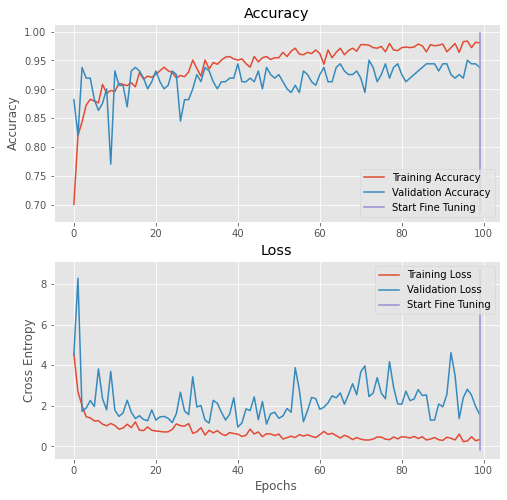

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 3.2892 - accuracy: 0.9297

2/4 [==============>...............] - ETA: 1s - loss: 3.1079 - accuracy: 0.9297

3/4 [=====================>........] - ETA: 1s - loss: 2.5242 - accuracy: 0.9401

4/4 [==============================] - ETA: 0s - loss: 2.5943 - accuracy: 0.9365

4/4 [==============================] - 13s 3s/step - loss: 2.5943 - accuracy: 0.9365


[2.5943267345428467, 0.936475396156311]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

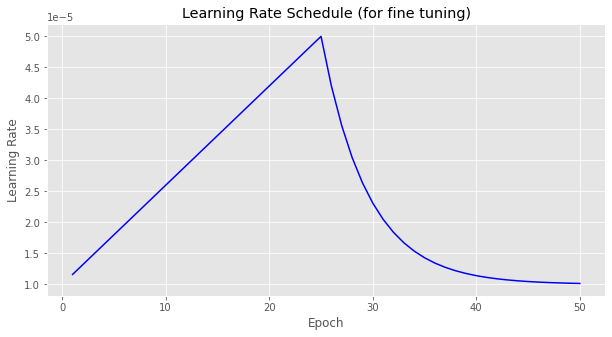

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 971 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1637 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 5s - loss: 0.2199 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 5s - loss: 0.3347 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 9s - loss: 0.4079 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 7s - loss: 0.4703 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 8s - loss: 0.6097 - accuracy: 0.9609

 7/16 [============>.................] - ETA: 9s - loss: 0.5226 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 9s - loss: 0.4754 - accuracy: 0.9688

 9/16 [===============>..............] - ETA: 7s - loss: 0.5086 - accuracy: 0.9670

10/16 [=================>............] - ETA: 6s - loss: 0.4942 - accuracy: 0.9688

11/16 [===================>..........] - ETA: 5s - loss: 0.4493 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 4s - loss: 0.4160 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 2s - loss: 0.3842 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 1s - loss: 0.3589 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 0s - loss: 0.3732 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.9743

16/16 [==============================] - 19s 1s/step - loss: 0.3690 - accuracy: 0.9743 - val_loss: 1.5705 - val_accuracy: 0.9379



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1546 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.1074 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.0718 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 16s - loss: 0.1644 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.2645 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 14s - loss: 0.3623 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 11s - loss: 0.3733 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 10s - loss: 0.3625 - accuracy: 0.9648

 9/16 [===============>..............] - ETA: 8s - loss: 0.3733 - accuracy: 0.9653 

10/16 [=================>............] - ETA: 7s - loss: 0.3526 - accuracy: 0.9672

11/16 [===================>..........] - ETA: 5s - loss: 0.3449 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 4s - loss: 0.3411 - accuracy: 0.9701

13/16 [=======================>......] - ETA: 3s - loss: 0.3545 - accuracy: 0.9700

14/16 [=========================>....] - ETA: 2s - loss: 0.3434 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.4051 - accuracy: 0.9688

16/16 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.9670

16/16 [==============================] - 20s 1s/step - loss: 0.4633 - accuracy: 0.9670 - val_loss: 1.5693 - val_accuracy: 0.9441



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0799 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 6s - loss: 0.3845 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 8s - loss: 0.4763 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 7s - loss: 0.5757 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 12s - loss: 0.5090 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 14s - loss: 0.4725 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 12s - loss: 0.4479 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.3974 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3544 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.4339 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 6s - loss: 0.4092 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.4202 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3896 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.3618 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3376 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.9794

16/16 [==============================] - 19s 1s/step - loss: 0.3338 - accuracy: 0.9794 - val_loss: 1.5857 - val_accuracy: 0.9441



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/16 [>.............................] - ETA: 0s - loss: 0.9977 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 5s - loss: 0.5933 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 14s - loss: 0.4103 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.3077 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 11s - loss: 0.3770 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 9s - loss: 0.3452 - accuracy: 0.9740 

 7/16 [============>.................] - ETA: 11s - loss: 0.3616 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.3414 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3285 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2956 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 6s - loss: 0.3138 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.2987 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2900 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2976 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2853 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9784

16/16 [==============================] - 19s 1s/step - loss: 0.2821 - accuracy: 0.9784 - val_loss: 1.5786 - val_accuracy: 0.9441



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/16 [>.............................] - ETA: 0s - loss: 1.9271e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 13s - loss: 0.0034 - accuracy: 1.0000   

 3/16 [====>.........................] - ETA: 10s - loss: 0.0025 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 10s - loss: 0.2266 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 12s - loss: 0.2488 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 13s - loss: 0.2074 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 12s - loss: 0.1908 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 11s - loss: 0.1669 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 10s - loss: 0.2844 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2836 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.3072 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2816 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.2614 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2592 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.9856

16/16 [==============================] - 20s 1s/step - loss: 0.2849 - accuracy: 0.9856 - val_loss: 1.5802 - val_accuracy: 0.9441



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2645 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 12s - loss: 0.1322 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 17s - loss: 0.3101 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 13s - loss: 0.2732 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 19s - loss: 0.2185 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 17s - loss: 0.3580 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 16s - loss: 0.3477 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 13s - loss: 0.3554 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 11s - loss: 0.4297 - accuracy: 0.9740

10/16 [=================>............] - ETA: 9s - loss: 0.3885 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 7s - loss: 0.3532 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3350 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3092 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2993 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.9763

16/16 [==============================] - 21s 1s/step - loss: 0.3063 - accuracy: 0.9763 - val_loss: 1.5882 - val_accuracy: 0.9441



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3766 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 6s - loss: 0.5838 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 6s - loss: 0.3898 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 7s - loss: 0.2924 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 9s - loss: 0.2734 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 11s - loss: 0.2288 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 11s - loss: 0.2160 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.1918 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 8s - loss: 0.1705 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 7s - loss: 0.1543 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.1457 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 4s - loss: 0.1335 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1347 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1251 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1322 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.1307 - accuracy: 0.9835 - val_loss: 1.5872 - val_accuracy: 0.9441



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1304 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.4344 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 19s - loss: 0.7578 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 15s - loss: 0.6473 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 13s - loss: 0.6812 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 13s - loss: 0.5677 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.7655 - accuracy: 0.9621

 8/16 [==============>...............] - ETA: 10s - loss: 0.6968 - accuracy: 0.9648

 9/16 [===============>..............] - ETA: 8s - loss: 0.7658 - accuracy: 0.9618 

10/16 [=================>............] - ETA: 7s - loss: 0.7166 - accuracy: 0.9641

11/16 [===================>..........] - ETA: 6s - loss: 0.6643 - accuracy: 0.9659

12/16 [=====================>........] - ETA: 4s - loss: 0.6090 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.5622 - accuracy: 0.9712

14/16 [=========================>....] - ETA: 2s - loss: 0.5228 - accuracy: 0.9721

15/16 [===========================>..] - ETA: 1s - loss: 0.5051 - accuracy: 0.9708

16/16 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.4993 - accuracy: 0.9712 - val_loss: 1.5967 - val_accuracy: 0.9441



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/16 [>.............................] - ETA: 0s - loss: 0.8916 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 1.1766 - accuracy: 0.9453

 3/16 [====>.........................] - ETA: 9s - loss: 0.7845 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 11s - loss: 0.7162 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 17s - loss: 0.7223 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 16s - loss: 0.6078 - accuracy: 0.9635

 7/16 [============>.................] - ETA: 15s - loss: 0.5461 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 12s - loss: 0.4857 - accuracy: 0.9688

 9/16 [===============>..............] - ETA: 10s - loss: 0.4500 - accuracy: 0.9705

10/16 [=================>............] - ETA: 8s - loss: 0.4050 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.3682 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3760 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.4090 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.3838 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.3937 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.9743

16/16 [==============================] - 21s 1s/step - loss: 0.3911 - accuracy: 0.9743 - val_loss: 1.6056 - val_accuracy: 0.9441



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1986 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 4s - loss: 0.3632 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 10s - loss: 0.2841 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.3419 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 12s - loss: 0.4936 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 13s - loss: 0.4481 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 13s - loss: 0.4777 - accuracy: 0.9688

 8/16 [==============>...............] - ETA: 12s - loss: 0.4595 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 9s - loss: 0.4085 - accuracy: 0.9740 

10/16 [=================>............] - ETA: 8s - loss: 0.3849 - accuracy: 0.9750

11/16 [===================>..........] - ETA: 6s - loss: 0.3499 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3362 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.3213 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3068 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.3403 - accuracy: 0.9784 - val_loss: 1.6099 - val_accuracy: 0.9441



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1677 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.1713 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 14s - loss: 0.3454 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 16s - loss: 0.2743 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.2195 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.2281 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1955 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 10s - loss: 0.1712 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.2111 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.2871 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2795 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.3347 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3106 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2884 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2763 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.9753

16/16 [==============================] - 21s 1s/step - loss: 0.3939 - accuracy: 0.9753 - val_loss: 1.6201 - val_accuracy: 0.9441



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1459 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.0730 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 13s - loss: 0.2117 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 12s - loss: 0.2337 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 15s - loss: 0.2202 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 17s - loss: 0.1835 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.1638 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.2551 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.2268 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2683 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2803 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2569 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2639 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2499 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2820 - accuracy: 0.9794 - val_loss: 1.6085 - val_accuracy: 0.9441



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1456 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 5s - loss: 0.5479 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 8s - loss: 0.5130 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 7s - loss: 0.3848 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 16s - loss: 0.3590 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 16s - loss: 0.3026 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 14s - loss: 0.2968 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.2597 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.2399 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.2769 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.2609 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.2490 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2590 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.2589 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.2659 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.2629 - accuracy: 0.9773 - val_loss: 1.6249 - val_accuracy: 0.9441



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/16 [>.............................] - ETA: 0s - loss: 2.1903 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 3s - loss: 1.0952 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 11s - loss: 1.0203 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 10s - loss: 0.7653 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 18s - loss: 0.6126 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 17s - loss: 0.5732 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 16s - loss: 0.5262 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 13s - loss: 0.4745 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.4218 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.3899 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 7s - loss: 0.3578 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.3597 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.3464 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.3229 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.3024 - accuracy: 0.9804 - val_loss: 1.6406 - val_accuracy: 0.9441



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5174 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.6302 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 15s - loss: 0.5014 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.3760 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 14s - loss: 0.3370 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.4049 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 13s - loss: 0.3781 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.3312 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.2945 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.2791 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2636 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2604 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2404 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2307 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2169 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2144 - accuracy: 0.9835 - val_loss: 1.6459 - val_accuracy: 0.9441



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/16 [>.............................] - ETA: 0s - loss: 1.1286e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 5.6433e-05 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9948   

 4/16 [======>.......................] - ETA: 15s - loss: 0.0904 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 14s - loss: 0.0724 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 13s - loss: 0.0945 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 14s - loss: 0.1315 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 13s - loss: 0.2816 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 11s - loss: 0.2782 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.2504 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.2385 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2226 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 4s - loss: 0.2140 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1991 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2163 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9835

16/16 [==============================] - 22s 1s/step - loss: 0.2138 - accuracy: 0.9835 - val_loss: 1.6405 - val_accuracy: 0.9503



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6911 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 13s - loss: 0.4716 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 21s - loss: 0.3144 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 20s - loss: 0.4118 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.3856 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.4216 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.3613 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.3162 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.2983 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.3853 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 7s - loss: 0.3503 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.3211 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.3387 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.3145 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2971 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2950 - accuracy: 0.9825 - val_loss: 1.6446 - val_accuracy: 0.9503



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.1670 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 13s - loss: 0.2148 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.1659 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 13s - loss: 0.1476 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.1515 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.1736 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 11s - loss: 0.1636 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.1454 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.1583 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.1853 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.1965 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.1816 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.1686 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.1618 - accuracy: 0.9825 - val_loss: 1.6413 - val_accuracy: 0.9503



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2038 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.2558 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.2146 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.1968 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 13s - loss: 0.1855 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.1597 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.1498 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1991 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.1963 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2189 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.3108 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.2849 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2962 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2774 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2643 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9784

16/16 [==============================] - 21s 1s/step - loss: 0.2613 - accuracy: 0.9784 - val_loss: 1.6522 - val_accuracy: 0.9503



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/16 [>.............................] - ETA: 0s - loss: 1.2380e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 0.0841 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 10s - loss: 0.0560 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 12s - loss: 0.0337 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 13s - loss: 0.1087 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 10s - loss: 0.1931 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 9s - loss: 0.2629 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 7s - loss: 0.2458 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.2234 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2242 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.2070 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1923 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9876

16/16 [==============================] - 20s 1s/step - loss: 0.1895 - accuracy: 0.9876 - val_loss: 1.6597 - val_accuracy: 0.9503



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5867 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.2937 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 17s - loss: 0.3502 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 20s - loss: 0.4052 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 19s - loss: 0.3878 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 17s - loss: 0.3777 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 16s - loss: 0.4771 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 13s - loss: 0.5254 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.5658 - accuracy: 0.9740

10/16 [=================>............] - ETA: 9s - loss: 0.5715 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.5566 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.5466 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 3s - loss: 0.5047 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.4851 - accuracy: 0.9743

15/16 [===========================>..] - ETA: 1s - loss: 0.4743 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.9732

16/16 [==============================] - 21s 1s/step - loss: 0.4767 - accuracy: 0.9732 - val_loss: 1.6558 - val_accuracy: 0.9503



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/16 [>.............................] - ETA: 0s - loss: 3.2782e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.2863 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 18s - loss: 0.1943 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 14s - loss: 0.3217 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.2931 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.2566 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.3172 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 10s - loss: 0.3547 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 8s - loss: 0.3155 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 7s - loss: 0.3019 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.3283 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.3380 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3543 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.3419 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.9722

16/16 [==============================] - 20s 1s/step - loss: 0.3585 - accuracy: 0.9722 - val_loss: 1.6369 - val_accuracy: 0.9503



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/16 [>.............................] - ETA: 0s - loss: 1.9064e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 2.8320e-05 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 16s - loss: 0.0831 - accuracy: 0.9948   

 4/16 [======>.......................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 13s - loss: 0.0499 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 12s - loss: 0.1558 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 10s - loss: 0.1335 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9902 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1662 - accuracy: 0.9896

10/16 [=================>............] - ETA: 7s - loss: 0.1950 - accuracy: 0.9875

11/16 [===================>..........] - ETA: 6s - loss: 0.1868 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 4s - loss: 0.2192 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.2047 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2082 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1943 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9856

16/16 [==============================] - 19s 1s/step - loss: 0.2284 - accuracy: 0.9856 - val_loss: 1.6455 - val_accuracy: 0.9503



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0411 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 25s - loss: 0.0205 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 21s - loss: 0.6002 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 17s - loss: 0.4701 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 15s - loss: 0.4260 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 14s - loss: 0.4396 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 13s - loss: 0.3846 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.3491 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.3111 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.2822 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2658 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2437 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2249 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2172 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2211 - accuracy: 0.9825 - val_loss: 1.6370 - val_accuracy: 0.9503



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.1768 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 18s - loss: 0.4019 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 14s - loss: 0.3174 - accuracy: 0.9609

 5/16 [========>.....................] - ETA: 20s - loss: 0.3471 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 18s - loss: 0.3097 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 16s - loss: 0.3253 - accuracy: 0.9643

 8/16 [==============>...............] - ETA: 13s - loss: 0.3247 - accuracy: 0.9629

 9/16 [===============>..............] - ETA: 11s - loss: 0.3297 - accuracy: 0.9653

10/16 [=================>............] - ETA: 9s - loss: 0.2968 - accuracy: 0.9688 

11/16 [===================>..........] - ETA: 7s - loss: 0.2714 - accuracy: 0.9702

12/16 [=====================>........] - ETA: 5s - loss: 0.2490 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 3s - loss: 0.2347 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.2180 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.2034 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.2011 - accuracy: 0.9773 - val_loss: 1.6386 - val_accuracy: 0.9503



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3232 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 8s - loss: 0.6987 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 11s - loss: 0.4658 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.4333 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.3678 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.4185 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 13s - loss: 0.4302 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.3789 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.3525 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.4463 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 7s - loss: 0.4057 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3980 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3682 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3906 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3955 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.9743

16/16 [==============================] - 21s 1s/step - loss: 0.4331 - accuracy: 0.9743 - val_loss: 1.6378 - val_accuracy: 0.9503



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5154 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 9s - loss: 0.2577 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 14s - loss: 0.2843 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 20s - loss: 0.2846 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 18s - loss: 0.3011 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 16s - loss: 0.2595 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 13s - loss: 0.2996 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 12s - loss: 0.2963 - accuracy: 0.9757

10/16 [=================>............] - ETA: 9s - loss: 0.2813 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 7s - loss: 0.2558 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2345 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 4s - loss: 0.2165 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2232 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2257 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.9784

16/16 [==============================] - 22s 1s/step - loss: 0.2927 - accuracy: 0.9784 - val_loss: 1.6232 - val_accuracy: 0.9441



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 14s - loss: 0.3581 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 20s - loss: 0.2388 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 15s - loss: 0.1791 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 17s - loss: 0.1621 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2212 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1912 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1673 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 9s - loss: 0.1676 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 7s - loss: 0.1741 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.1583 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.1562 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1451 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1278 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9846

16/16 [==============================] - 21s 1s/step - loss: 0.1302 - accuracy: 0.9846 - val_loss: 1.6274 - val_accuracy: 0.9441



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2739 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.4281 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 14s - loss: 0.3613 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 13s - loss: 0.4009 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 20s - loss: 0.5304 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 18s - loss: 0.4420 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 17s - loss: 0.3977 - accuracy: 0.9710

 8/16 [==============>...............] - ETA: 13s - loss: 0.3583 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 11s - loss: 0.3189 - accuracy: 0.9757

10/16 [=================>............] - ETA: 9s - loss: 0.2870 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.2763 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2533 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 4s - loss: 0.3128 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2919 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.3096 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.9784

16/16 [==============================] - 22s 1s/step - loss: 0.3061 - accuracy: 0.9784 - val_loss: 1.6259 - val_accuracy: 0.9441



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1141 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.0571 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 13s - loss: 0.1283 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 12s - loss: 0.1721 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 15s - loss: 0.1605 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 12s - loss: 0.1376 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 11s - loss: 0.1204 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 10s - loss: 0.1259 - accuracy: 0.9896

10/16 [=================>............] - ETA: 8s - loss: 0.1133 - accuracy: 0.9906 

11/16 [===================>..........] - ETA: 7s - loss: 0.1804 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1910 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1892 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1757 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1650 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.1758 - accuracy: 0.9835 - val_loss: 1.6245 - val_accuracy: 0.9441



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.0141 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 15s - loss: 0.1865 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.1403 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.0984 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.1781 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.1713 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.1523 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1370 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1780 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2067 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2089 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2244 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2387 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2360 - accuracy: 0.9815 - val_loss: 1.6170 - val_accuracy: 0.9441



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1324 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 18s - loss: 0.1793 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 20s - loss: 0.2588 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 19s - loss: 0.3202 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 17s - loss: 0.2668 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 16s - loss: 0.2287 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.3373 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.3035 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2992 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.2863 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2643 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2572 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2401 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9856

16/16 [==============================] - 21s 1s/step - loss: 0.2420 - accuracy: 0.9856 - val_loss: 1.6265 - val_accuracy: 0.9441



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 5s - loss: 0.4393 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 5s - loss: 0.4128 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 9s - loss: 0.3559 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 11s - loss: 0.3259 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 11s - loss: 0.3425 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 9s - loss: 0.3104 - accuracy: 0.9777 

 8/16 [==============>...............] - ETA: 8s - loss: 0.2716 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 7s - loss: 0.2827 - accuracy: 0.9809

10/16 [=================>............] - ETA: 6s - loss: 0.2945 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.2731 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.2666 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2461 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2396 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2611 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9773

16/16 [==============================] - 19s 1s/step - loss: 0.2588 - accuracy: 0.9773 - val_loss: 1.6218 - val_accuracy: 0.9441



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3491 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.1745 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 13s - loss: 0.1164 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.2851 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 12s - loss: 0.2907 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.2725 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.2379 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.2082 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.1910 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.1731 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.1901 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2067 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1968 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2683 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2504 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9815

16/16 [==============================] - 21s 1s/step - loss: 0.2476 - accuracy: 0.9815 - val_loss: 1.6075 - val_accuracy: 0.9441



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1663 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 8s - loss: 0.1373 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 18s - loss: 0.0931 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 20s - loss: 0.0698 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 19s - loss: 0.1159 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 14s - loss: 0.1485 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 13s - loss: 0.1374 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9705

10/16 [=================>............] - ETA: 9s - loss: 0.1756 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.1596 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.1463 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.1531 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.1593 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.1575 - accuracy: 0.9804 - val_loss: 1.6079 - val_accuracy: 0.9441



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.0435 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 14s - loss: 0.1872 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.1404 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.1770 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.1977 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 13s - loss: 0.1988 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.2076 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.1857 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.1671 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.1519 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1409 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1301 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1621 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1513 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9866

16/16 [==============================] - 21s 1s/step - loss: 0.1496 - accuracy: 0.9866 - val_loss: 1.6113 - val_accuracy: 0.9441



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.0173 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 13s - loss: 0.1520 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.2753 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 13s - loss: 0.2256 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.3174 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 11s - loss: 0.2975 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 11s - loss: 0.3525 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3133 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.4251 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 7s - loss: 0.3864 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3967 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.3879 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.3605 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.3376 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.3337 - accuracy: 0.9773 - val_loss: 1.6236 - val_accuracy: 0.9441



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/16 [>.............................] - ETA: 0s - loss: 1.2807e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 19s - loss: 6.4387e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 14s - loss: 0.0155 - accuracy: 0.9948    

 4/16 [======>.......................] - ETA: 11s - loss: 0.0840 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 11s - loss: 0.0672 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 13s - loss: 0.0560 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 10s - loss: 0.0438 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 9s - loss: 0.1757 - accuracy: 0.9878 

10/16 [=================>............] - ETA: 8s - loss: 0.1581 - accuracy: 0.9891

11/16 [===================>..........] - ETA: 6s - loss: 0.1437 - accuracy: 0.9901

12/16 [=====================>........] - ETA: 4s - loss: 0.1579 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1828 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1699 - accuracy: 0.9900

15/16 [===========================>..] - ETA: 1s - loss: 0.1586 - accuracy: 0.9906

16/16 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9907

16/16 [==============================] - 19s 1s/step - loss: 0.1568 - accuracy: 0.9907 - val_loss: 1.6289 - val_accuracy: 0.9441



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/16 [>.............................] - ETA: 0s - loss: 5.7741e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 18s - loss: 0.1049 - accuracy: 0.9844   

 3/16 [====>.........................] - ETA: 13s - loss: 0.0700 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 12s - loss: 0.3029 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 11s - loss: 0.3260 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 13s - loss: 0.2717 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.2329 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 11s - loss: 0.2149 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2828 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.2813 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 6s - loss: 0.2558 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.3589 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3901 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3756 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3691 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.3649 - accuracy: 0.9773 - val_loss: 1.6383 - val_accuracy: 0.9441



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0831 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 8s - loss: 0.0416 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 7s - loss: 0.0277 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 8s - loss: 0.0208 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 10s - loss: 0.1447 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 12s - loss: 0.1206 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 11s - loss: 0.1034 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 11s - loss: 0.1664 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 10s - loss: 0.1479 - accuracy: 0.9913

10/16 [=================>............] - ETA: 8s - loss: 0.1334 - accuracy: 0.9922 

11/16 [===================>..........] - ETA: 6s - loss: 0.1498 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 4s - loss: 0.1775 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1638 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1731 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9876

16/16 [==============================] - 19s 1s/step - loss: 0.1597 - accuracy: 0.9876 - val_loss: 1.6442 - val_accuracy: 0.9441



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 4s - loss: 0.0046 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 7s - loss: 0.0427 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 8s - loss: 0.0321 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 15s - loss: 0.0214 - accuracy: 0.9974

 7/16 [============>.................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 10s - loss: 0.1280 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 8s - loss: 0.2526 - accuracy: 0.9878 

10/16 [=================>............] - ETA: 7s - loss: 0.2507 - accuracy: 0.9875

11/16 [===================>..........] - ETA: 6s - loss: 0.2348 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 4s - loss: 0.2153 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.2209 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2052 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 1s - loss: 0.2023 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9866

16/16 [==============================] - 19s 1s/step - loss: 0.2000 - accuracy: 0.9866 - val_loss: 1.6442 - val_accuracy: 0.9441



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2877 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.1438 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 17s - loss: 0.2690 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.2200 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 17s - loss: 0.1743 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 16s - loss: 0.2052 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.2260 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.2268 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2819 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.2932 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2688 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2481 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2812 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2900 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.2867 - accuracy: 0.9804 - val_loss: 1.6289 - val_accuracy: 0.9441



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7713 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 13s - loss: 0.4514 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 13s - loss: 0.3292 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 12s - loss: 0.2617 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.4044 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 14s - loss: 0.3370 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 13s - loss: 0.3024 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 12s - loss: 0.2647 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.2940 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2859 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 7s - loss: 0.2599 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2845 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2646 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2692 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2760 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.2729 - accuracy: 0.9773 - val_loss: 1.6353 - val_accuracy: 0.9441



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5919 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.3024 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.2016 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.1512 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.2727 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.3724 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.3309 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.3030 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.2873 - accuracy: 0.9792

10/16 [=================>............] - ETA: 9s - loss: 0.2688 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2531 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2423 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2236 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2098 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2317 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.2291 - accuracy: 0.9825 - val_loss: 1.6448 - val_accuracy: 0.9441



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/16 [>.............................] - ETA: 0s - loss: 1.0245e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1085 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 17s - loss: 0.1044 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.3309 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 17s - loss: 0.2758 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 15s - loss: 0.3082 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.2720 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2418 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.2186 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 6s - loss: 0.2004 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.2286 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2112 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2217 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2282 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9825

16/16 [==============================] - 20s 1s/step - loss: 0.2257 - accuracy: 0.9825 - val_loss: 1.6454 - val_accuracy: 0.9441



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0933 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.4075 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 17s - loss: 0.4340 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.4580 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.3664 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 11s - loss: 0.3138 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 13s - loss: 0.4222 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 12s - loss: 0.3884 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 11s - loss: 0.3453 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.3700 - accuracy: 0.9750 

11/16 [===================>..........] - ETA: 7s - loss: 0.3369 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.3148 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2935 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2844 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2654 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9794

16/16 [==============================] - 21s 1s/step - loss: 0.2624 - accuracy: 0.9794 - val_loss: 1.6287 - val_accuracy: 0.9441



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3284 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.3146 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 10s - loss: 0.2104 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.1578 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 16s - loss: 0.1512 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.1446 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1265 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.1243 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1120 - accuracy: 0.9891 

11/16 [===================>..........] - ETA: 6s - loss: 0.1018 - accuracy: 0.9901

12/16 [=====================>........] - ETA: 5s - loss: 0.1367 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1262 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1172 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1149 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9876

16/16 [==============================] - 20s 1s/step - loss: 0.1136 - accuracy: 0.9876 - val_loss: 1.6129 - val_accuracy: 0.9441



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.0733 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 18s - loss: 0.1962 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 14s - loss: 0.2252 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 11s - loss: 0.1828 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 12s - loss: 0.1525 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 10s - loss: 0.1308 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.1903 - accuracy: 0.9824 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1780 - accuracy: 0.9826

10/16 [=================>............] - ETA: 6s - loss: 0.1602 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.1456 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.1718 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1950 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1811 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.1976 - accuracy: 0.9835 - val_loss: 1.6026 - val_accuracy: 0.9441



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5386 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 11s - loss: 0.2731 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 20s - loss: 0.1828 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 16s - loss: 0.3807 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 14s - loss: 0.3292 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2991 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.2812 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.2460 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 9s - loss: 0.2543 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.2453 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.2521 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2431 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2330 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2410 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2224 - accuracy: 0.9835 - val_loss: 1.6198 - val_accuracy: 0.9441



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/16 [>.............................] - ETA: 0s - loss: 7.2626e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.1563 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 11s - loss: 0.1042 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 17s - loss: 0.0625 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9948

 7/16 [============>.................] - ETA: 15s - loss: 0.0738 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 12s - loss: 0.0675 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 10s - loss: 0.0709 - accuracy: 0.9896

10/16 [=================>............] - ETA: 9s - loss: 0.1038 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.1462 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.1427 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1317 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1396 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1403 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.1387 - accuracy: 0.9825 - val_loss: 1.6285 - val_accuracy: 0.9503


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

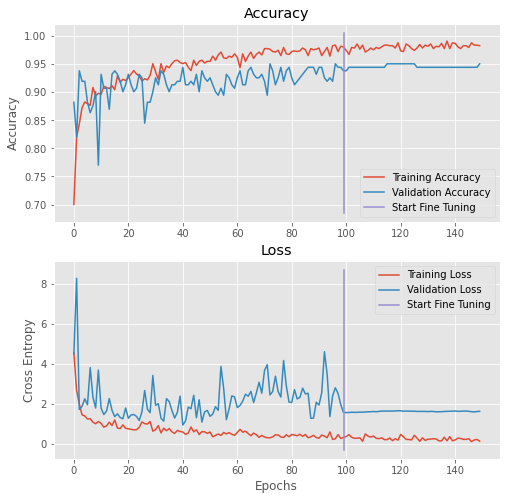

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 3.5533 - accuracy: 0.9062

2/4 [==============>...............] - ETA: 1s - loss: 2.9110 - accuracy: 0.9258

3/4 [=====================>........] - ETA: 1s - loss: 2.1902 - accuracy: 0.9375

4/4 [==============================] - ETA: 0s - loss: 2.0692 - accuracy: 0.9426

4/4 [==============================] - 5s 1s/step - loss: 2.0692 - accuracy: 0.9426


[2.0692458152770996, 0.9426229596138]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9426229508196722
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       148
           1       0.96      0.96      0.96       340

    accuracy                           0.94       488
   macro avg       0.93      0.93      0.93       488
weighted avg       0.94      0.94      0.94       488



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

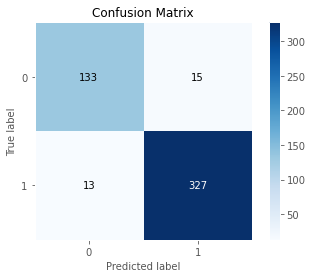

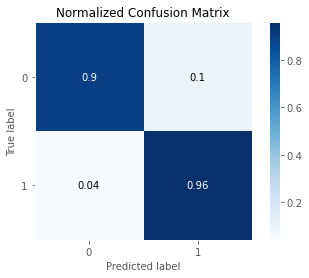

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

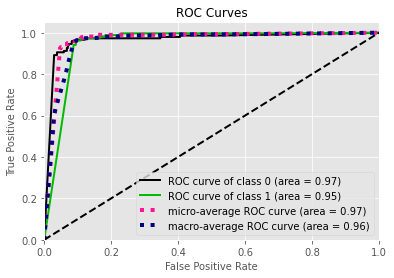

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       148
           1       0.96      0.96      0.96       340

    accuracy                           0.94       488
   macro avg       0.93      0.93      0.93       488
weighted avg       0.94      0.94      0.94       488

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.90      0.96      0.90      0.93      0.86       148
          1       0.96      0.96      0.90      0.96      0.93      0.87       340

avg / total       0.94      0.94      0.92      0.94      0.93      0.87       488

